<a href="https://colab.research.google.com/github/Eshaa2001/Data-Drift-Trends/blob/main/KL_Divergence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
# Install necessary libraries
!pip install pandas numpy matplotlib scipy ipywidgets

In [43]:
import pandas as pd
from google.colab import files

# Upload the dataset
uploaded = files.upload()

# Load the dataset
file_name = list(uploaded.keys())[0]
data = pd.read_csv(file_name)

# Display the first few rows
data.head()


Saving E-commerce Customer Behavior - Sheet1.csv to E-commerce Customer Behavior - Sheet1 (3).csv


,Customer ID,Gender,Age,City,Membership Type,Total Spend,Items Purchased,Average Rating,Discount Applied,Days Since Last Purchase,Satisfaction Level
0,101,Female,29,New York,Gold,1120.20,14,4.6,True,25,Satisfied
1,102,Male,34,Los Angeles,Silver,780.50,11,4.1,False,18,Neutral
2,103,Female,43,Chicago,Bronze,510.75,9,3.4,True,42,Unsatisfied
3,104,Male,30,San Francisco,Gold,1480.30,19,4.7,False,12,Satisfied
4,105,Male,27,Miami,Silver,720.40,13,4.0,True,55,Unsatisfied


In [44]:
import numpy as np
from scipy.stats import entropy

def calculate_kl_divergence(ref_data, prod_data, numerical_features, bins=10):
    """Calculate KL divergence for numerical features."""
    kl_results = {}
    for feature in numerical_features:
        ref_hist, bin_edges = np.histogram(ref_data[feature], bins=bins, density=True)
        prod_hist, _ = np.histogram(prod_data[feature], bins=bin_edges, density=True)

        # Avoid division by zero and log(0)
        ref_hist += 1e-10
        prod_hist += 1e-10

        kl_div = entropy(ref_hist, prod_hist)
        kl_results[feature] = kl_div
    return kl_results

def simulate_drift(prod_data, feature, drift_type="scale", factor=1.2):
    """Simulate drift by scaling or replacing feature values."""
    if drift_type == "scale":
        prod_data[feature] *= factor
    elif drift_type == "replace":
        prod_data[feature] = np.random.choice(prod_data[feature].unique(), size=len(prod_data))
    return prod_data

In [45]:
# Split data into reference (training) and production (live) datasets
np.random.seed(42)
ref_data = data.sample(frac=0.7, random_state=42)
prod_data = data.drop(ref_data.index)

# Define features
numerical_features = ['Total Spend', 'Items Purchased', 'Average Rating', 'Days Since Last Purchase']

In [46]:
import matplotlib.pyplot as plt
from ipywidgets import interact, Dropdown, FloatSlider

@interact(
    feature=Dropdown(options=numerical_features, description="Feature"),
    drift_type=Dropdown(options=["scale", "replace"], description="Drift Type"),
    factor=FloatSlider(value=1.2, min=0.5, max=2.0, step=0.1, description="Drift Factor"),
)
def interactive_drift_monitor(feature, drift_type, factor):
    # Simulate drift
    prod_data_drifted = simulate_drift(prod_data.copy(), feature, drift_type, factor)

    # Calculate KL divergence
    kl_results = calculate_kl_divergence(ref_data, prod_data_drifted, numerical_features)

    # Display KL divergence
    print("\nKL Divergence Results:")
    for feat, kl in kl_results.items():
        print(f"{feat}: {kl:.4f}")

    # Plot reference vs production distributions for the selected feature
    plt.figure(figsize=(10, 5))
    plt.hist(ref_data[feature], bins=10, alpha=0.7, label="Reference Data", density=True)
    plt.hist(prod_data_drifted[feature], bins=10, alpha=0.7, label="Production Data", density=True)
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Density")
    plt.legend()
    plt.show()


interactive(children=(Dropdown(description='Feature', options=('Total Spend', 'Items Purchased', 'Average Rati…

Plots KL Divergence over time, helping users visualize which features are drifting most.

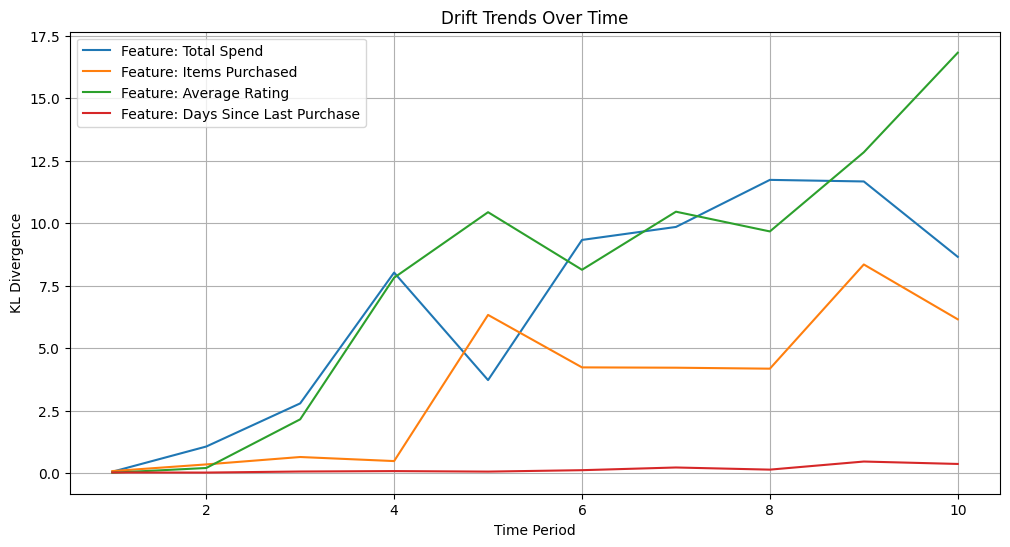

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Simulate drift over multiple time periods
def simulate_drift_over_time(ref_data, prod_data, feature, drift_type="scale", periods=10):
    drift_values = []
    for t in range(periods):
        # Incrementally increase drift factor
        factor = 1 + (t / periods) * 0.5  # Drift factor increases over time
        drifted_data = simulate_drift(prod_data.copy(), feature, drift_type, factor)
        kl_divergence = calculate_kl_divergence(ref_data, drifted_data, [feature])
        drift_values.append(kl_divergence[feature])
    return drift_values

# Plot drift trends over time
def plot_drift_trends(ref_data, prod_data, features, periods=10):
    plt.figure(figsize=(12, 6))
    for feature in features:
        drift_values = simulate_drift_over_time(ref_data, prod_data, feature, periods=periods)
        plt.plot(range(1, periods + 1), drift_values, label=f"Feature: {feature}")

    plt.title("Drift Trends Over Time")
    plt.xlabel("Time Period")
    plt.ylabel("KL Divergence")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
plot_drift_trends(ref_data, prod_data, numerical_features, periods=10)


##Model Retraining: Trigger on Drift Threshold

In [48]:
# Define a drift threshold
DRIFT_THRESHOLD = 0.05

# Check if drift exceeds threshold
def check_drift_and_retrain(ref_data, prod_data, features):
    kl_results = calculate_kl_divergence(ref_data, prod_data, features)

    # Check if any feature exceeds the threshold
    drifted_features = {feature: kl for feature, kl in kl_results.items() if kl > DRIFT_THRESHOLD}

    if drifted_features:
        print("Drift detected in the following features:")
        for feature, kl in drifted_features.items():
            print(f"{feature}: KL Divergence = {kl:.4f}")
        print("\nTriggering model retraining...\n")
        retrain_model(ref_data, prod_data)
    else:
        print("No significant drift detected.")

# Simulate model retraining
def retrain_model(ref_data, prod_data):
    print("Retraining the recommendation model with updated data...")
    # Combine reference and production data
    updated_data = pd.concat([ref_data, prod_data]).drop_duplicates()

    # Rebuild the recommendation system
    global user_item_matrix, similarity_matrix
    user_item_matrix = updated_data.pivot_table(index='Customer ID', columns='City', values='Total Spend').fillna(0)
    similarity_matrix = cosine_similarity(normalize(user_item_matrix))
    print("Model retrained successfully!")

# Example usage
check_drift_and_retrain(ref_data, prod_data, numerical_features)


Drift detected in the following features:
Total Spend: KL Divergence = 0.0611
Items Purchased: KL Divergence = 0.0872

Triggering model retraining...

Retraining the recommendation model with updated data...
Model retrained successfully!


In [49]:
# Simulate stronger drift
drifted_data = simulate_drift(prod_data.copy(), 'Total Spend', 'scale', factor=1.5)
check_drift_and_retrain(ref_data, drifted_data, numerical_features)


Drift detected in the following features:
Total Spend: KL Divergence = 8.5974
Items Purchased: KL Divergence = 0.0872

Triggering model retraining...

Retraining the recommendation model with updated data...
Model retrained successfully!


In [50]:
extended_features = ['Total Spend', 'Items Purchased', 'Age', 'Days Since Last Purchase']
check_drift_and_retrain(ref_data, prod_data, extended_features)


Drift detected in the following features:
Total Spend: KL Divergence = 0.0611
Items Purchased: KL Divergence = 0.0872
Age: KL Divergence = 0.7057

Triggering model retraining...

Retraining the recommendation model with updated data...
Model retrained successfully!


In [51]:
# Example of feature weighting
feature_weights = {'Total Spend': 2.0, 'Items Purchased': 1.0, 'Average Rating': 0.5, 'Days Since Last Purchase': 0.5}
weighted_kl_divergence = {feature: kl * feature_weights[feature] for feature, kl in kl_results.items()}
print("Weighted KL Divergence:", weighted_kl_divergence)

Weighted KL Divergence: {'Total Spend': 0.1222311353787142, 'Items Purchased': 0.08718464815070454, 'Average Rating': 0.011029323084447545, 'Days Since Last Purchase': 0.015742124843379536}


In [52]:
# Assuming 'data' is your DataFrame
city_mapping = dict(zip(data['Customer ID'], data['City']))

# Example usage
print(city_mapping)

{101: 'New York', 102: 'Los Angeles', 103: 'Chicago', 104: 'San Francisco', 105: 'Miami', 106: 'Houston', 107: 'New York', 108: 'Los Angeles', 109: 'Chicago', 110: 'San Francisco', 111: 'Miami', 112: 'Houston', 113: 'New York', 114: 'Los Angeles', 115: 'Chicago', 116: 'San Francisco', 117: 'Miami', 118: 'Houston', 119: 'New York', 120: 'Los Angeles', 121: 'Chicago', 122: 'San Francisco', 123: 'Miami', 124: 'Houston', 125: 'New York', 126: 'Los Angeles', 127: 'Chicago', 128: 'San Francisco', 129: 'Miami', 130: 'Houston', 131: 'New York', 132: 'Los Angeles', 133: 'Chicago', 134: 'San Francisco', 135: 'Miami', 136: 'Houston', 137: 'New York', 138: 'Los Angeles', 139: 'Chicago', 140: 'San Francisco', 141: 'Miami', 142: 'Houston', 143: 'New York', 144: 'Los Angeles', 145: 'Chicago', 146: 'San Francisco', 147: 'Miami', 148: 'Houston', 149: 'New York', 150: 'Los Angeles', 151: 'Chicago', 152: 'San Francisco', 153: 'Miami', 154: 'Houston', 155: 'New York', 156: 'Los Angeles', 157: 'Chicago', 1

In [53]:
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity

# Build the user-item matrix
user_item_matrix = data.pivot_table(index='Customer ID', columns='City', values='Total Spend').fillna(0)

# Normalize the matrix
user_item_matrix_normalized = normalize(user_item_matrix, norm='l2')

# Compute the similarity matrix
similarity_matrix = cosine_similarity(user_item_matrix_normalized)

In [54]:
def get_recommendations(user_id, similarity_matrix, user_item_matrix, top_n=5):
    """Generate recommendations for a given user."""
    # Find the index of the user
    user_index = user_item_matrix.index.get_loc(user_id)

    # Get similarity scores for the user
    scores = similarity_matrix[user_index]

    # Sort indices by similarity, excluding the user themselves
    recommended_indices = scores.argsort()[::-1][1:top_n + 1]

    # Find the cities/items with the highest scores
    recommended_items = user_item_matrix.iloc[recommended_indices].sum(axis=0).sort_values(ascending=False).index[:top_n]

    return recommended_items

In [55]:
# Create a city mapping dynamically from the dataset
city_mapping = dict(zip(data['Customer ID'], data['City']))

@interact(user_id=Dropdown(options=user_item_matrix.index, description="User ID"))
def recommend_for_user(user_id):
    # Get recommendations (City names directly)
    recommendations = get_recommendations(user_id, similarity_matrix, user_item_matrix)

    # Display the recommendations in readable format
    print(f"Recommendations for User {user_id} based on similar behavior:")
    for idx, city in enumerate(recommendations, start=1):
        print(f"{idx}. {city}")

interactive(children=(Dropdown(description='User ID', options=(101, 102, 103, 104, 105, 106, 107, 108, 109, 11…

In [56]:
@interact(user_id=Dropdown(options=user_item_matrix.index, description="User ID"))
def visualize_recommendations(user_id):
    # Get recommendations
    recommendations = get_recommendations(user_id, similarity_matrix, user_item_matrix)

    # Plot the recommendations
    plt.figure(figsize=(8, 4))
    plt.barh(recommendations[::-1], range(1, len(recommendations) + 1))
    plt.xlabel("Rank")
    plt.ylabel("Recommended City")
    plt.title(f"Top Recommendations for User {user_id}")
    plt.gca().invert_yaxis()
    plt.show()

interactive(children=(Dropdown(description='User ID', options=(101, 102, 103, 104, 105, 106, 107, 108, 109, 11…